In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jsbsim_utils import Logger, trim, simulate

Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

In [2]:
op_ground, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/vt-fps': 0,
        'gear/gear-cmd-norm': 1,
        'propulsion/engine/pitch-angle-rad': np.deg2rad(0),
        'fcs/throttle-cmd-norm': 0,
        'fcs/aileron-cmd-norm': 0,
        'fcs/elevator-cmd-norm': 0,
        'fcs/rudder-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 0],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    tol=1e-12,
)
op_ground

 final_simplex: (array([[4.85765918e-04, 3.70162834e+00],
       [4.85765918e-04, 3.70162834e+00],
       [4.85765918e-04, 3.70162834e+00]]), array([9.03386380e-12, 9.03386381e-12, 9.03386381e-12]))
           fun: 9.033863801684596e-12
       message: 'Optimization terminated successfully.'
          nfev: 300
           nit: 152
        status: 0
       success: True
             x: array([4.85765918e-04, 3.70162834e+00])


{'ic/vt-fps': 0,
 'gear/gear-cmd-norm': 1,
 'propulsion/engine/pitch-angle-rad': 0.0,
 'fcs/throttle-cmd-norm': 0,
 'fcs/aileron-cmd-norm': 0,
 'fcs/elevator-cmd-norm': 0,
 'fcs/rudder-cmd-norm': 0,
 'fcs/left-brake-cmd-norm': 1,
 'fcs/right-brake-cmd-norm': 1,
 'fcs/center-brake-cmd-norm': 1,
 'ic/theta-rad': 0.0004857659179286267,
 'ic/h-agl-ft': 3.7016283364266105}

In [3]:
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=True)

In [4]:
fdm.resume_integration()
fdm.get_propulsion().get_steady_state()

False

<AxesSubplot:xlabel='t, sec'>

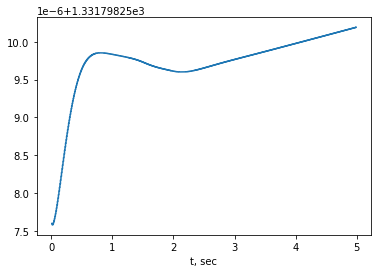

In [5]:
log_ground['propulsion/engine/thrust-lbs'].plot()

In [6]:
op_hover, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/h-agl-ft': 10,
        'ic/vd-fps': 0,
        'ic/vn-fps': 0*np.cos(np.deg2rad(280)),
        'ic/ve-fps': 0*np.sin(np.deg2rad(280)),
        'ic/theta-rad': 0,
        'gear/gear-cmd-norm': 1,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
    ],
    x0=[0.1, 0, np.deg2rad(90)],
    verbose=True,
    bounds=[[0, 2], [-1, 1], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12
)
op_hover

      fun: 8.881051951361937e-12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.44181750e-06,  2.29155517e-08,  1.49438468e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 16
     njev: 20
   status: 0
  success: True
        x: array([ 1.00984854, -0.19994762,  1.57079635])


{'ic/h-agl-ft': 10,
 'ic/vd-fps': 0,
 'ic/vn-fps': 0.0,
 'ic/ve-fps': -0.0,
 'ic/theta-rad': 0,
 'gear/gear-cmd-norm': 1,
 'fcs/left-brake-cmd-norm': 0,
 'fcs/right-brake-cmd-norm': 0,
 'fcs/center-brake-cmd-norm': 0,
 'fcs/throttle-cmd-norm': 1.0098485353943794,
 'fcs/elevator-cmd-norm': -0.19994762313695125,
 'propulsion/engine/pitch-angle-rad': 1.5707963530211393}

In [ ]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=5,
    realtime=True)

In [ ]:
def cost_cruise(fdm):
    # modify cost to also penalize throttle
    delta = fdm['propulsion/engine/pitch-angle-rad']
    theta = fdm['attitude/theta-rad']
    drag = fdm['forces/fwx-aero-lbs']
    lift = fdm['forces/fwz-aero-lbs']
    alpha = fdm['aero/alpha-rad']
    throttle = fdm['fcs/throttle-cmd-norm']
    
    udot = fdm['accelerations/udot-ft_sec2']
    vdot = fdm['accelerations/vdot-ft_sec2']
    wdot = fdm['accelerations/wdot-ft_sec2']
    pdot = fdm['accelerations/pdot-rad_sec2']
    qdot = fdm['accelerations/qdot-rad_sec2']
    rdot = fdm['accelerations/rdot-rad_sec2']
    return udot**2 + vdot**2 + wdot**2 + pdot**2 + qdot**2 + rdot**2 - 1e-3*(lift/drag)**2 + 1e-3*(theta < 0)
        
op_cruise, fdm = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-rad': 0,
        'ic/vt-fps': 1100,
        'ic/h-agl-ft': 30,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        #'propulsion/engine/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
        'propulsion/engine/pitch-angle-rad',
    ],
    cost=cost_cruise,
    x0=[0.1, 0, 0, 0, 0, 0, 0],
    verbose=True,
    bounds=[[0, 2], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)]],
    tol=1e-12,
)
op_cruise

In [ ]:
log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=5,
    realtime=True)